In [22]:
import sys
sys.path.append('../')
import load_data_luigi as ld
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Feature variability

In [2]:
data = ld.RootDetectorFiles(event_id=1325)
data = ld.CreateAngles(create_from=data)

/Users/claus/anaconda3/envs/tf2/lib/python3.7/site-packages/luigi/parameter.py:283: UserWarning: Parameter "event_id" with value "1325" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/Users/claus/anaconda3/envs/tf2/lib/python3.7/site-packages/luigi/parameter.py:283: UserWarning: Parameter "create_from" with value "RootDetectorFiles(event_id=1325)" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))


In [3]:
hits, cells, particles, truth = data.load()

DEBUG: Checking if CreateAngles(create_from=RootDetectorFiles(event_id=1325)) is complete
INFO: Informed scheduler that task   CreateAngles_RootDetectorFile_0aeef28717   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=594709474, workers=1, host=Clauss-MacBook-Pro.local, username=claus, pid=56618) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 complete ones were encountered:
    - 1 CreateAngles(create_from=RootDetectorFiles(event_id=1325))

Did not run any tasks
This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



In [4]:
merged = hits.merge(truth, on='hit_id')

In [5]:
state_components = ['x', 'y', 'z', 'phi', 'theta']
scaled_state = StandardScaler().fit_transform(merged[state_components])

In [6]:
merged_scaled = merged.copy()
merged_scaled[state_components] = scaled_state

In [7]:
particle_std_devs = []
for _, group in merged_scaled.groupby('particle_id'):
    particle_std_devs.append(np.std(group[state_components]))
particle_std_devs = np.array(particle_std_devs)

Text(0,0.5,'Variability in [σ]')

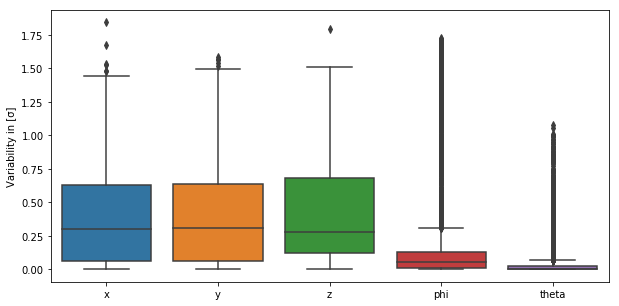

In [8]:
plt.figure(figsize=(10,5))
sns.boxplot(data=pd.DataFrame(particle_std_devs, columns=state_components))
plt.ylabel('Variability in [σ]')

In [9]:
particle_std_devs.shape

(10428, 5)

# Linear assignment problem

In [5]:
from association.association_row_col import RowColumnDenseAssociation
from association.new_lstm import AssociationLstm
from network_configuration import TrackerConfiguration
import tensorflow as tf
from scipy.optimize import linear_sum_assignment

In [6]:
row_col_config = TrackerConfiguration(total_no_particles=30,
                                      total_no_measurements=30,
                                      assoc_dense_row_col_no_layers = 1)

In [7]:
row_col_model = tf.keras.Sequential([
    RowColumnDenseAssociation(row_col_config),
    tf.keras.layers.Softmax()
                                    ])
row_col_model.compile('adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics='accuracy')

In [8]:
def generate_linear_assignment_problem(no_rows, no_cols, batch_size=None):
    if batch_size is None:
        return np.random.uniform(-1., 0., [no_rows, no_cols])
    else:
        return np.random.uniform(-1., 0., [batch_size, no_rows, no_cols])

def solve_linear_assignment_problem(problem, batch_size=None):
    if batch_size is None:
        row_ind, col_ind = linear_sum_assignment(problem)
        solution = np.zeros_like(problem, dtype=np.int32)
        solution[row_ind, col_ind] = 1
    else:
        solution = []
        for i, batch in enumerate(problem):
            row_ind, col_ind = linear_sum_assignment(batch)
            batch_matrix = np.zeros_like(batch, dtype=np.int32)
            batch_matrix[row_ind, col_ind] = 1
            solution.append(batch_matrix)
        solution = np.stack(solution, axis=0)
    return solution

def generate_linear_assignment_problems(no_rows, no_cols, c=None, return_truth=True, batch_size=None):
    i = 0
    while True:
        problem = generate_linear_assignment_problem(no_rows, no_cols, batch_size=batch_size)
        if return_truth:
            solution = solve_linear_assignment_problem(problem, batch_size=batch_size)
            yield problem, solution
        else:
            yield problem
        i = i + 1
        if c is not None:
            if i >= c:
                return

In [14]:
row_col_model.fit(generate_linear_assignment_problems(30, 30, batch_size=16), batch_size=16, epochs=1, steps_per_epoch=50000)

50000/50000 [==============================] - 242s 5ms/step - loss: 1.2230 - accuracy: 0.5309


In [15]:
row_col_model.evaluate(generate_linear_assignment_problems(30, 30, batch_size=16), batch_size=16, steps=200)

200/200 [==============================] - 1s 5ms/step - loss: 1.1415 - accuracy: 0.5441


[1.141472339630127, 0.5440624952316284]

In [9]:
lstm_config = TrackerConfiguration(total_no_particles=30,
                                   total_no_measurements=30,
                                   assoc_lstm_hidden_units=30*30,
                                   
                                   assoc_dense_row_col_no_layers = 1)
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Permute((2,1)),
    AssociationLstm(lstm_config),
    tf.keras.layers.Permute((2,1)),
    tf.keras.layers.Softmax()
])
lstm_model.compile('rmsprop', loss=tf.keras.losses.CategoricalCrossentropy(), metrics='accuracy')

In [17]:
lstm_model.fit(generate_linear_assignment_problems(30, 30, batch_size=16), batch_size=16, epochs=1, steps_per_epoch=50000)

50000/50000 [==============================] - 988s 20ms/step - loss: 1.5174 - accuracy: 0.4884


In [18]:
lstm_model.evaluate(generate_linear_assignment_problems(30, 30, batch_size=16), batch_size=16, steps=200)

200/200 [==============================] - 2s 11ms/step - loss: 1.1414 - accuracy: 0.5687


[1.1414340734481812, 0.5687395930290222]

In [10]:
class AssocMilanLstm(AssociationLstm):
    def call(self, c_matrix):
        c_matrix_input = tf.reshape(c_matrix, [tf.shape(c_matrix)[0], -1])
        c_matrix_input = tf.tile(tf.expand_dims(c_matrix_input, axis=1), [1, self.no_particles, 1])
        c_matrix_input = tf.reshape(c_matrix_input, [tf.shape(c_matrix)[0], self.no_particles, self.no_particles * self.no_measurements])
        lstm_output = c_matrix_input
        for lstm, nn in zip(self.lstms, self.nns):
            lstm_output = lstm(lstm_output)
            lstm_output = nn(lstm_output)
        return lstm_output

lstm_milan_layer = AssocMilanLstm(lstm_config)

lstm_milan_model = tf.keras.Sequential([
    lstm_milan_layer,
    tf.keras.layers.Softmax()
])

lstm_milan_model.compile('rmsprop', loss=tf.keras.losses.CategoricalCrossentropy(), metrics='accuracy')

In [20]:
lstm_milan_model.fit(generate_linear_assignment_problems(30, 30, batch_size=16), batch_size=16, epochs=1, steps_per_epoch=50000)

50000/50000 [==============================] - 1084s 22ms/step - loss: 3.3966 - accuracy: 0.0363


In [21]:
lstm_milan_model.evaluate(generate_linear_assignment_problems(30, 30, batch_size=16), batch_size=16, steps=200)

200/200 [==============================] - 2s 11ms/step - loss: 3.3927 - accuracy: 0.0391


[3.392688035964966, 0.039104167371988297]

In [11]:
class Negative(tf.keras.layers.Layer):
    def call(self, inp):
        return -inp

identity_model = tf.keras.Sequential([Negative(), tf.keras.layers.Softmax()])
identity_model.compile('adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics='accuracy')
identity_model.evaluate(generate_linear_assignment_problems(30, 30, batch_size=16), batch_size=16, steps=200)

200/200 [==============================] - 1s 3ms/step - loss: 2.9925 - accuracy: 0.5217


[2.992452383041382, 0.5217499732971191]

In [12]:
def get_losses_and_accuracies(model, steps=5000):
    problems = list(generate_linear_assignment_problems(30, 30, batch_size=1, c=steps))
    Xs = [problem[0] for problem in problems]
    Ys = [problem[1] for problem in problems]
    evaluation = [model.evaluate(x, y, verbose=False) for x, y in zip(Xs, Ys)]
    #losses = tf.keras.losses.CategoricalCrossentropy()(Ys, prediction)
    #accuracies = tf.keras.metrics.Accuracy()(Ys, prediction)
    losses = [e[0] for e in evaluation]
    accuracies = [e[1] for e in evaluation]
    return losses, accuracies

In [27]:
row_col_losses, row_col_accuracies = get_losses_and_accuracies(row_col_model, steps=5000)

In [28]:
lstm_losses, lstm_accuracies = get_losses_and_accuracies(lstm_model)

In [29]:
lstm_milan_losses, lstm_milan_accuracies = get_losses_and_accuracies(lstm_milan_model)

In [30]:
identity_losses, identity_accuracies = get_losses_and_accuracies(identity_model)

Text(0.5,1,'Association Model Losses')

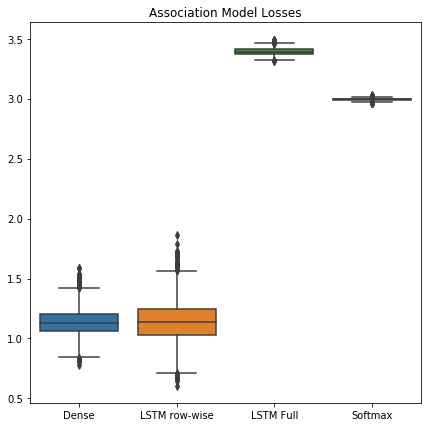

In [31]:
plt.figure(figsize=(7,7))
sns.boxplot(data=pd.DataFrame({'Dense': row_col_losses, 'LSTM row-wise': lstm_losses, 'LSTM Full': lstm_milan_losses, 'Softmax': identity_losses}))
plt.title('Association Model Losses')

Text(0.5,1,'Association Model Accuracies')

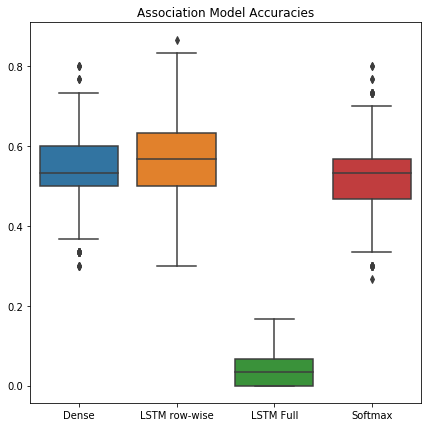

In [32]:
plt.figure(figsize=(7,7))
sns.boxplot(data=pd.DataFrame(data={'Dense': row_col_accuracies, 'LSTM row-wise': lstm_accuracies, 'LSTM Full': lstm_milan_accuracies, 'Softmax': identity_accuracies}))
plt.title('Association Model Accuracies')

In [13]:
test_problem = generate_linear_assignment_problem(30, 30, 1)

In [14]:
import time

def test_time_and_plot(model_fn, name):
    pred_times = []
    train_times = []
    for size in range(2, 50):
        model = model_fn(size, size)
        total_pred_time = 0
        total_train_time = 0
        for _ in range(10):
            test_problem = generate_linear_assignment_problem(size, size, 16)
            test_solution = solve_linear_assignment_problem(test_problem, batch_size=16)
            
            start = time.time()
            model.predict(test_problem, verbose=False)
            end = time.time()
            
            prediction_time = end - start
            total_pred_time += prediction_time
            
            start = time.time()
            model.fit(test_problem, test_solution, verbose=False)
            end = time.time()
            
            training_time = end - start
            total_train_time += training_time
            
        train_times.append(total_train_time / 10)
        pred_times.append(total_pred_time / 10)
    
    plt.title('{} Avg. Training Times'.format(name))
    plt.plot(np.arange(2, 50), train_times)
    plt.xlabel('Instance size')
    plt.ylabel('Time [s]')
    plt.show()
    
    plt.title('{} Avg. Inference Times'.format(name))
    plt.plot(np.arange(2, 50), pred_times)
    plt.xlabel('Instance size')
    plt.ylabel('Time [s]')
    plt.show()

In [15]:
def row_col_model_fn(rows, cols):
    config = TrackerConfiguration(total_no_particles=rows,
                                      total_no_measurements=cols,
                                      assoc_dense_row_col_no_layers = 1)
    
    model = tf.keras.Sequential([
    RowColumnDenseAssociation(config),
    tf.keras.layers.Softmax()])
    model.compile('adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics='accuracy')
    return model

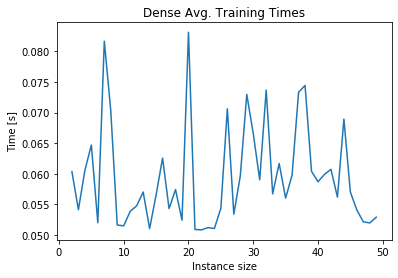

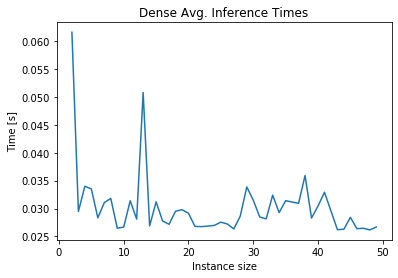

In [16]:
test_time_and_plot(row_col_model_fn, 'Dense')

In [17]:
def lstm_milan_fn(rows, cols):
    
    lstm_config = TrackerConfiguration(total_no_particles=rows,
                                   total_no_measurements=cols,
                                   assoc_lstm_hidden_units=rows*cols,
                                   
                                   assoc_dense_row_col_no_layers = 1)
    
    lstm_milan_layer = AssocMilanLstm(lstm_config)

    model = tf.keras.Sequential([
        lstm_milan_layer,
        tf.keras.layers.Softmax()
    ])

    model.compile('rmsprop', loss=tf.keras.losses.CategoricalCrossentropy(), metrics='accuracy')
    return model

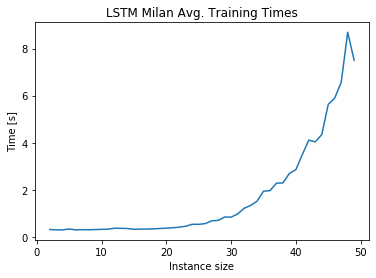

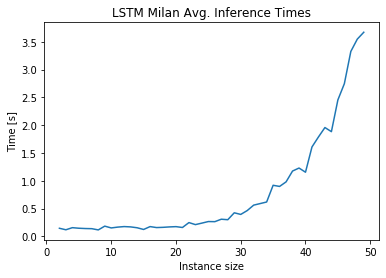

In [18]:
test_time_and_plot(lstm_milan_fn, 'LSTM Milan')

In [19]:
def lstm_row_fn(rows, cols):
    
    lstm_config = TrackerConfiguration(total_no_particles=rows,
                                   total_no_measurements=cols,
                                   assoc_lstm_hidden_units=rows*cols,
                                   
                                   assoc_dense_row_col_no_layers = 1)
    
    lstm_layer = AssociationLstm(lstm_config)

    model = tf.keras.Sequential([
        lstm_layer,
        tf.keras.layers.Softmax()
    ])

    model.compile('rmsprop', loss=tf.keras.losses.CategoricalCrossentropy(), metrics='accuracy')
    return model

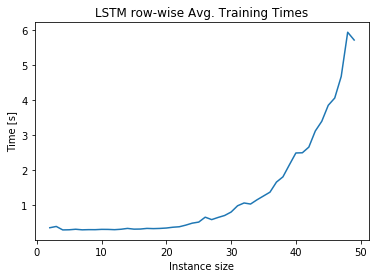

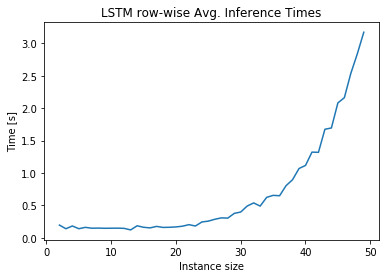

In [20]:
test_time_and_plot(lstm_row_fn, 'LSTM row-wise')

# Bucket evaluation

In [2]:
from functools import reduce

In [3]:
theta_buckets = ld.RootRangeDetectorFiles(start_range=1000, end_range=1005)
theta_buckets = ld.DerivedRangeDetectorFiles(create_from=theta_buckets, derive_task=ld.CreateAngles)
theta_buckets = ld.DerivedRangeDetectorFiles(create_from=theta_buckets, derive_task=ld.create_sequences(56))
theta_buckets = ld.DerivedRangeDetectorFiles(create_from=theta_buckets, derive_task=ld.CreateNormalized)

/Users/claus/anaconda3/envs/tf2/lib/python3.7/site-packages/luigi/parameter.py:283: UserWarning: Parameter "start_range" with value "1000" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/Users/claus/anaconda3/envs/tf2/lib/python3.7/site-packages/luigi/parameter.py:283: UserWarning: Parameter "end_range" with value "1005" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/Users/claus/anaconda3/envs/tf2/lib/python3.7/site-packages/luigi/parameter.py:283: UserWarning: Parameter "derive_task" with value "<class 'load_data_luigi.CreateAngles'>" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/Users/claus/anaconda3/envs/tf2/lib/python3.7/site-packages/luigi/parameter.py:283: UserWarning: Parameter "create_from" with value "RootRangeDetectorFiles(start_range

DEBUG: Checking if DerivedRangeDetectorFiles(derive_task=<class 'load_data_luigi.CreateNormalized'>, create_from=DerivedRangeDetectorFiles(derive_task=<class 'load_data_luigi.create_sequences.<locals>.CreateSequences'>, create_from=DerivedRangeDetectorFiles(derive_task=<class 'load_data_luigi.CreateAngles'>, create_from=RootRangeDetectorFiles(start_range=1000, end_range=1005)))) is complete
/Users/claus/anaconda3/envs/tf2/lib/python3.7/site-packages/luigi/parameter.py:283: UserWarning: Parameter "create_from" with value "RootDetectorFiles(event_id=1000)" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/Users/claus/anaconda3/envs/tf2/lib/python3.7/site-packages/luigi/parameter.py:283: UserWarning: Parameter "create_from" with value "RootDetectorFiles(event_id=1001)" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/Users/claus/ana

(0, 8000)

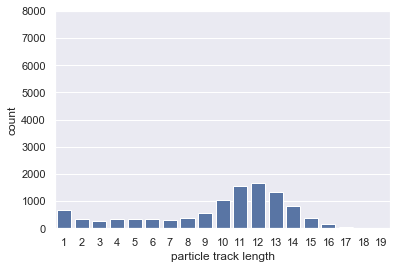

In [4]:
event = next(theta_buckets.load())
hits, _, _, truth = event
merged = hits.merge(truth, on='hit_id')
merged = merged[merged['particle_id'] != 0]
particle_lengths = merged.groupby('particle_id').size()
sns.set()
sns.countplot(x=particle_lengths, color='C0')
plt.xlabel('particle track length')
plt.ylim(0,8000)

In [5]:
def particle_lengths_per_bucket(event):
    hits, _, _, truth = event
    merged = hits.merge(truth, on='hit_id')
    particle_lengths_dict = dict()
    for bucket_id, bucket in merged.groupby('sequence_id'):
        bucket = bucket[bucket['particle_id'] != 0]
        particle_lengths = list(bucket.groupby('particle_id').size())
        particle_lengths_dict[bucket_id] = particle_lengths
    return particle_lengths_dict

In [6]:
def bucket_particle_lengths_distribution(event):
    particle_lengths_dict = particle_lengths_per_bucket(event)
    len_list = reduce(lambda a,b: a+b, particle_lengths_dict.values())
    particle_lengths = len_list
    sns.set()
    sns.countplot(x=particle_lengths, color='C0')
    plt.xlabel('particle track length')
    plt.ylim(0,8000)

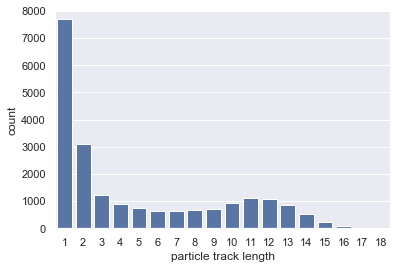

In [7]:
bucket_particle_lengths_distribution(next(theta_buckets.load()))

In [8]:
hits, _ ,_ ,_ = next(theta_buckets.load())
hits['sequence_id'].nunique()

56

In [9]:
hits.groupby(['sequence_id', 'volume_id', 'layer_id']).count().max()

hit_id       491
x            491
y            491
z            491
module_id    491
phi          491
theta        491
dtype: int64

In [10]:
annoy_buckets = ld.RootRangeDetectorFiles(start_range=1000, end_range=1005)
annoy_buckets = ld.DerivedRangeDetectorFiles(create_from=annoy_buckets, derive_task=ld.create_annoy_sequences(2500))
annoy_buckets = ld.DerivedRangeDetectorFiles(create_from=annoy_buckets, derive_task=ld.CreateAngles)
annoy_buckets = ld.DerivedRangeDetectorFiles(create_from=annoy_buckets, derive_task=ld.CreateNormalized)

/Users/claus/anaconda3/envs/tf2/lib/python3.7/site-packages/luigi/parameter.py:283: UserWarning: Parameter "derive_task" with value "<class 'load_data_luigi.create_annoy_sequences.<locals>.CreateAnnoySequences'>" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/Users/claus/anaconda3/envs/tf2/lib/python3.7/site-packages/luigi/parameter.py:283: UserWarning: Parameter "create_from" with value "DerivedRangeDetectorFiles(derive_task=<class 'load_data_luigi.create_annoy_sequences.<locals>.CreateAnnoySequences'>, create_from=RootRangeDetectorFiles(start_range=1000, end_range=1005))" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/Users/claus/anaconda3/envs/tf2/lib/python3.7/site-packages/luigi/parameter.py:283: UserWarning: Parameter "create_from" with value "DerivedRangeDetectorFiles(derive_task=<class 'load_data_luigi.CreateAngles'>

DEBUG: Checking if DerivedRangeDetectorFiles(derive_task=<class 'load_data_luigi.CreateNormalized'>, create_from=DerivedRangeDetectorFiles(derive_task=<class 'load_data_luigi.CreateAngles'>, create_from=DerivedRangeDetectorFiles(derive_task=<class 'load_data_luigi.create_annoy_sequences.<locals>.CreateAnnoySequences'>, create_from=RootRangeDetectorFiles(start_range=1000, end_range=1005)))) is complete
/Users/claus/anaconda3/envs/tf2/lib/python3.7/site-packages/luigi/parameter.py:283: UserWarning: Parameter "create_from" with value "CreateAnnoySequences(create_from=RootDetectorFiles(event_id=1000))" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/Users/claus/anaconda3/envs/tf2/lib/python3.7/site-packages/luigi/parameter.py:283: UserWarning: Parameter "create_from" with value "CreateAnnoySequences(create_from=RootDetectorFiles(event_id=1001))" is not of type string.
  warnings.warn('Parameter "{}" with value

INFO: Running Worker with 4 processes
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 16
DEBUG: Asking scheduler for work...
INFO: [pid 53623] Worker Worker(salt=711230875, workers=4, host=Clauss-MacBook-Pro.local, username=claus, pid=53618) running   CreateAnnoySequences(create_from=RootDetectorFiles(event_id=1004))
DEBUG: Pending tasks: 15
DEBUG: Asking scheduler for work...
INFO: [pid 53624] Worker Worker(salt=711230875, workers=4, host=Clauss-MacBook-Pro.local, username=claus, pid=53618) running   CreateAnnoySequences(create_from=RootDetectorFiles(event_id=1003))
DEBUG: Pending tasks: 14
DEBUG: Asking scheduler for work...
INFO: [pid 53625] Worker Worker(salt=711230875, workers=4, host=Clauss-MacBook-Pro.local, username=claus, pid=53618) running   CreateAnnoySequences(create_from=RootDetectorFiles(event_id=1002))
DEBUG: Pending tasks: 13
DEBUG: 4 running tasks, waiting for next task to finish
INFO: [pid 53626] Worker Worker(salt=711230875, workers=4, host=Clauss-MacBook-P

INFO: [pid 53632] Worker Worker(salt=711230875, workers=4, host=Clauss-MacBook-Pro.local, username=claus, pid=53618) done      CreateNormalized(create_from=CreateAngles(create_from=CreateAnnoySequences(create_from=RootDetectorFiles(event_id=1003))))
INFO: Informed scheduler that task   CreateNormalized_CreateAngles_cre_8d99c834f6   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
DEBUG: CreateNormalized_CreateAngles_cre_ac4824cfe1 is currently run by worker Worker(salt=711230875, workers=4, host=Clauss-MacBook-Pro.local, username=claus, pid=53618)
DEBUG: CreateAnnoySequences_RootDetectorFile_1bcbd8e3db is currently run by worker Worker(salt=711230875, workers=4, host=Clauss-MacBook-Pro.local, username=claus, pid=53618)
DEBUG: CreateNormalized_CreateAngles_cre_24f852d9c4 is currently run by worker Worker(salt=711230875, workers=4, host=Clauss-MacBook-Pro.local, username=claus, pid=53618)
DEBUG: Asking scheduler for work

DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
DEBUG: CreateNormalized_CreateAngles_cre_f99702a5e3 is currently run by worker Worker(salt=711230875, workers=4, host=Clauss-MacBook-Pro.local, username=claus, pid=53618)
INFO: [pid 53637] Worker Worker(salt=711230875, workers=4, host=Clauss-MacBook-Pro.local, username=claus, pid=53618) done      CreateNormalized(create_from=CreateAngles(create_from=CreateAnnoySequences(create_from=RootDetectorFiles(event_id=1000))))
INFO: Informed scheduler that task   CreateNormalized_CreateAngles_cre_f99702a5e3   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 1
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
DEBUG: DerivedRangeDetectorFiles_DerivedRangeDete__class__load_dat_1727f70173 is currently run by worker Worker(salt=711230875, workers=4, host=Clauss-MacBook-Pro.local, username=claus, pid=53618)
INFO: [pid 53638] Work

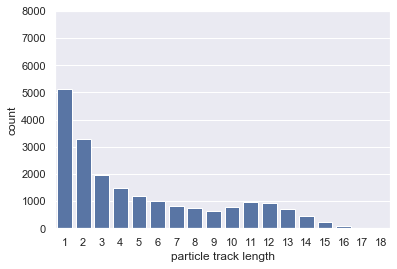

In [11]:
bucket_particle_lengths_distribution(next(annoy_buckets.load()))

In [12]:
hits, _ ,_ ,_ = next(annoy_buckets.load())
hits['sequence_id'].nunique()

107

In [13]:
hits.groupby(['sequence_id', 'volume_id', 'layer_id']).count().max()

hit_id       480
x            480
y            480
z            480
module_id    480
phi          480
theta        480
dtype: int64

In [14]:
phi_buckets = ld.RootRangeDetectorFiles(start_range=1000, end_range=1005)
phi_buckets = ld.DerivedRangeDetectorFiles(create_from=phi_buckets, derive_task=ld.CreateAngles)
phi_buckets = ld.DerivedRangeDetectorFiles(create_from=phi_buckets, derive_task=ld.create_sequences(38))
phi_buckets = ld.DerivedRangeDetectorFiles(create_from=phi_buckets, derive_task=ld.create_phi_sequences(2))
phi_buckets = ld.DerivedRangeDetectorFiles(create_from=phi_buckets, derive_task=ld.CreateNormalized)

/Users/claus/anaconda3/envs/tf2/lib/python3.7/site-packages/luigi/parameter.py:283: UserWarning: Parameter "derive_task" with value "<class 'load_data_luigi.create_phi_sequences.<locals>.CreatePhiSequences'>" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/Users/claus/anaconda3/envs/tf2/lib/python3.7/site-packages/luigi/parameter.py:283: UserWarning: Parameter "create_from" with value "DerivedRangeDetectorFiles(derive_task=<class 'load_data_luigi.create_phi_sequences.<locals>.CreatePhiSequences'>, create_from=DerivedRangeDetectorFiles(derive_task=<class 'load_data_luigi.create_sequences.<locals>.CreateSequences'>, create_from=DerivedRangeDetectorFiles(derive_task=<class 'load_data_luigi.CreateAngles'>, create_from=RootRangeDetectorFiles(start_range=1000, end_range=1005))))" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))


DEBUG: Checking if DerivedRangeDetectorFiles(derive_task=<class 'load_data_luigi.CreateNormalized'>, create_from=DerivedRangeDetectorFiles(derive_task=<class 'load_data_luigi.create_phi_sequences.<locals>.CreatePhiSequences'>, create_from=DerivedRangeDetectorFiles(derive_task=<class 'load_data_luigi.create_sequences.<locals>.CreateSequences'>, create_from=DerivedRangeDetectorFiles(derive_task=<class 'load_data_luigi.CreateAngles'>, create_from=RootRangeDetectorFiles(start_range=1000, end_range=1005))))) is complete
/Users/claus/anaconda3/envs/tf2/lib/python3.7/site-packages/luigi/parameter.py:283: UserWarning: Parameter "create_from" with value "CreatePhiSequences(create_from=CreateSequences(create_from=CreateAngles(create_from=RootDetectorFiles(event_id=1000))))" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))
/Users/claus/anaconda3/envs/tf2/lib/python3.7/site-packages/luigi/parameter.py:283: UserWarning: 

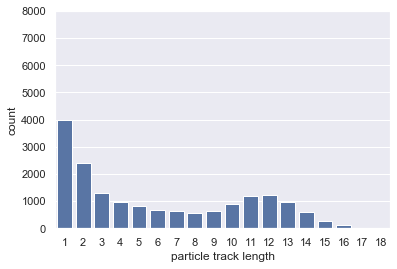

In [15]:
bucket_particle_lengths_distribution(next(phi_buckets.load()))

In [16]:
hits, _ ,_ ,_ = next(phi_buckets.load())
hits['sequence_id'].nunique()

56

In [17]:
hits.groupby(['sequence_id', 'volume_id', 'layer_id']).count().max()

hit_id       456
x            456
y            456
z            456
module_id    456
phi          456
theta        456
dtype: int64

# Number of hits and particles

In [29]:
events1 = ld.RootRangeDetectorFiles(start_range=1000, end_range=2400)
events2 = ld.RootRangeDetectorFiles(start_range=2450, end_range=2820)

/Users/claus/anaconda3/envs/tf2/lib/python3.7/site-packages/luigi/parameter.py:283: UserWarning: Parameter "end_range" with value "2400" is not of type string.
  warnings.warn('Parameter "{}" with value "{}" is not of type string.'.format(param_name, param_value))


In [36]:
def get_average_hits_and_particles(event_ranges):
    no_hits = []
    no_parts = []
    
    for e in event_ranges:
        for hits, _, _, truth in e.load():
            no_hits.append(len(hits))
            no_parts.append(truth['particle_id'].nunique() - 1)
        
    return no_hits, no_parts

In [37]:
no_hits, no_parts = get_average_hits_and_particles([events1, events2])

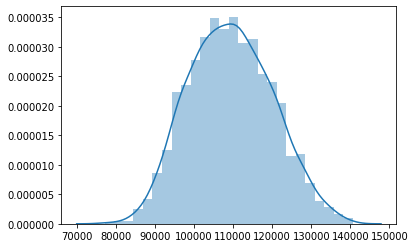

In [38]:
sns.distplot(no_hits)

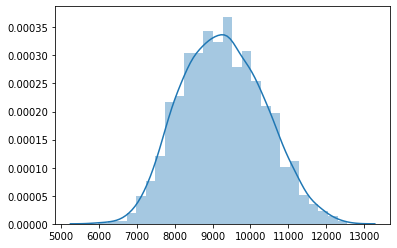

In [39]:
sns.distplot(no_parts)

In [40]:
np.mean(no_hits)

109394.62881355932

In [41]:
np.mean(no_parts)

9277.931073446327